In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize_scalar

project_root = Path.cwd().parent
print(f"Project root: {project_root}")

Project root: /Users/david/Code/msc


In [14]:
# User input: run folder name
run_name = input("Enter the run name: ").strip()
run_folder = project_root / "runs" / run_name
distance_process_path = run_folder / "distance_process.csv"

if not distance_process_path.exists():
    raise FileNotFoundError(f"No distance_process.csv found at {distance_process_path}")

df = pd.read_csv(distance_process_path)

# Use redshift from ztf_cleansed for the Hubble diagram
ztf_cleansed_path = project_root / "ztf_cleansed.csv"
ztf_df = pd.read_csv(ztf_cleansed_path)
z_from_ztf = df["ztf_id"].map(ztf_df.set_index("ZTFID")["redshift"])
df["host_redshift"] = z_from_ztf.fillna(df["host_redshift"])

# Filter to z > 0 and sort by redshift for plotting
dfp = df[df["host_redshift"] > 0].sort_values("host_redshift").copy()
# Drop invalid rows for distance moduli or residuals
valid = np.isfinite(dfp["distance_modulus_u_obs"]) & np.isfinite(dfp["host_redshift"])
dfp = dfp.loc[valid]
if len(dfp) < len(df):
    print(f"Dropped {len(df) - len(dfp)} rows")
print(f"Loaded {len(dfp)} objects from {distance_process_path}")
dfp.head()

Loaded 976 objects from /Users/david/Code/msc/runs/test3/distance_process.csv


,ztf_id,host_redshift,ncall,ndof,chisq,t0,x0,x1,c,apparent_mag_B,distance_modulus_u_obs,mu_th,resid
350,ZTF19aacgslb,0.00452,109,102,27059.171339,58510.552516,0.083152,-0.084587,0.010775,13.208455,32.523212,31.441887,1.081325
520,ZTF19aatlmbo,0.00775,269,65,11959.943740,58619.807914,0.044062,-1.791445,0.018994,13.897784,32.948099,32.618090,0.330010
249,ZTF18acbvgqw,0.00867,119,17,555.743431,58438.641469,0.053969,-2.284826,-0.031314,13.676057,32.813256,32.863963,-0.050707
90,ZTF18aawlfnj,0.01000,115,28,228.045933,60149.074035,0.007312,0.068994,0.123148,15.849467,34.837366,33.175318,1.662048
314,ZTF18acwutbr,0.01100,102,24,176.893959,58483.033806,0.005028,-0.117851,0.112144,16.256028,35.251881,33.383939,1.867942


Saved to /Users/david/Code/msc/runs/test3/hubble_diagram.png


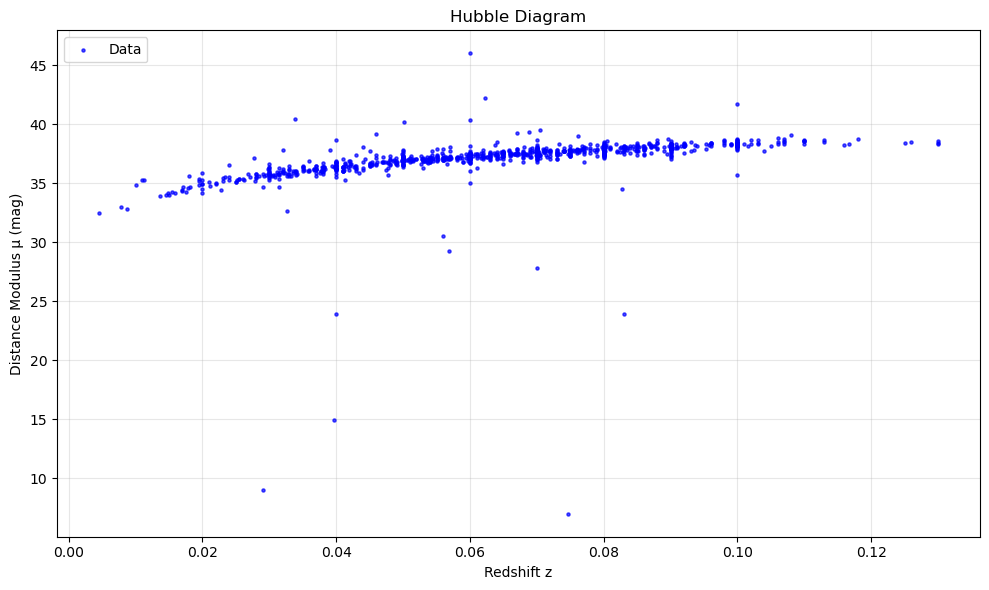

Saved to /Users/david/Code/msc/runs/test3/hubble_residuals.png


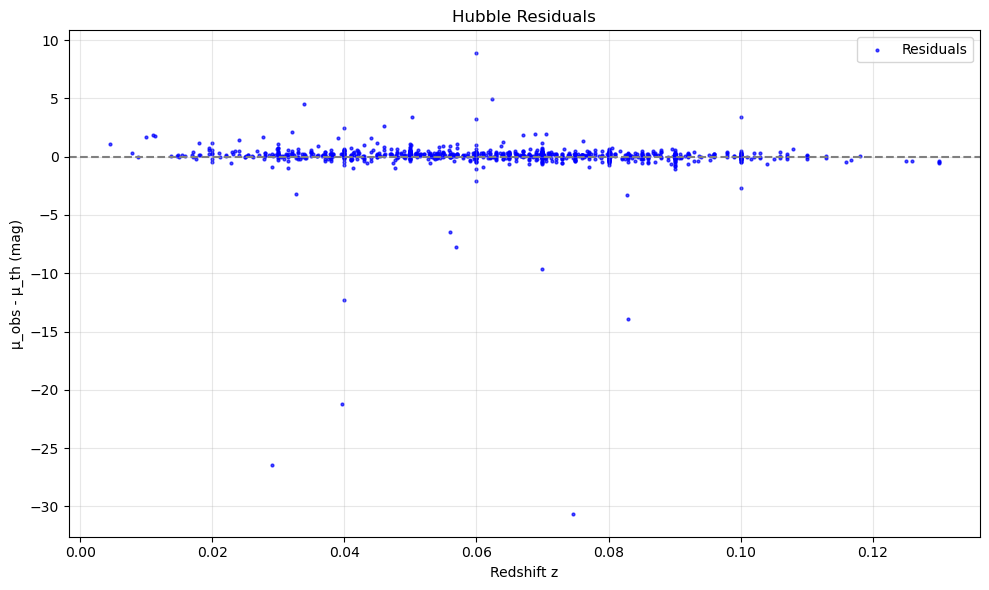

In [33]:
# Pull out numpy arrays
z_data = dfp["host_redshift"].to_numpy()
mu_obs = dfp["distance_modulus_u_obs"].to_numpy()

Om0 = 0.3  # fixed matter density for all models

def mu_theory(z, H0=70.0, Om0=Om0):
    """Distance modulus u(z) for flat ΛCDM."""
    return FlatLambdaCDM(H0=H0, Om0=Om0).distmod(z).value

# Smooth z grid for theory curves
z_min = max(1e-4, z_data.min() * 0.9)
z_max = z_data.max() * 1.1
z_smooth = np.linspace(z_min, z_max, 300)

# Hubble diagram
plt.figure(figsize=(10, 6))

plt.scatter(dfp["host_redshift"], mu_obs, label="Data", color="blue", s=5, zorder=5, alpha=0.7)

plt.xlabel("Redshift z")
plt.ylabel("Distance Modulus μ (mag)")
plt.title("Hubble Diagram")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

out_path = run_folder / "hubble_diagram.png"
plt.savefig(out_path, dpi=150)
print(f"Saved to {out_path}")
plt.show()

# Residuals: u_obs − u_th for best-fit.  - brighter,  + dimmer 
mu_th_best = mu_theory(z_data)
resid_best = mu_obs - mu_th_best

plt.figure(figsize=(10, 6))
plt.axhline(0, color="gray", ls="--")
plt.scatter(dfp["host_redshift"], resid_best, label="Residuals", color="blue", s=4, alpha=0.7)

plt.xlabel("Redshift z")
plt.ylabel("μ_obs - μ_th (mag)")
plt.title("Hubble Residuals")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

resid_path = run_folder / "hubble_residuals.png"
plt.savefig(resid_path, dpi=150)
print(f"Saved to {resid_path}")
plt.show()